In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from skimage.io import imread, imshow
import cv2
from skfuzzy.cluster import cmeans
import itertools
import scipy

import warnings
warnings.filterwarnings('ignore')

In [2]:
image = imread('bacteries_1.jpg')
image1 = imread('bacteries_2.jpg')

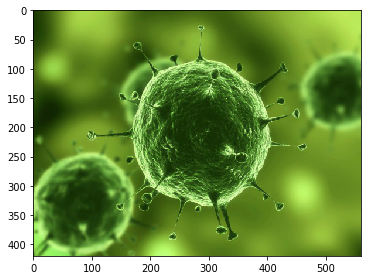

In [4]:
imshow(image);

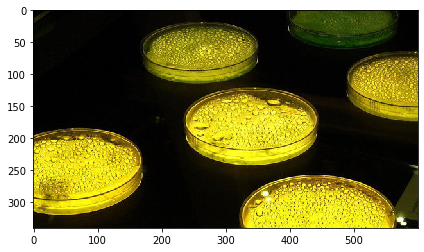

In [5]:
imshow(image1);

### KMeans

In [6]:
def convert_to_2d(image):
    image_2d = image.reshape((-1,3)) 
    image_2d = np.float32(image_2d)
    
    return image_2d

In [7]:
image_2d = convert_to_2d(image)
image1_2d = convert_to_2d(image1)

In [8]:
MAX_ITER = 100
EPSILON = 0.85
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, MAX_ITER, EPSILON)
ATTEMPTS = 10

In [9]:
CENTERS_METHODS = (cv2.KMEANS_PP_CENTERS, cv2.KMEANS_RANDOM_CENTERS)

In [10]:
CLUSTERS_RANGE = range(1, 11)

In [11]:
def calculate_intracluster_distance_sum(cluster_elements, centroid):
    return sum([scipy.spatial.distance.sqeuclidean(centroid, element) for element in cluster_elements])

In [25]:
def get_intercluster_distance(centroid, centers):
#     if len(centers) > 1:
#         return scipy.spatial.distance.pdist(centers, 'sqeuclidean').min()
    return sum([scipy.spatial.distance.sqeuclidean(centroid, centroid_other) for centroid_other in centers])
#     else:
#         return 0

In [26]:
def xie_benie(segmented_image, centers):
    xb = sum([calculate_intracluster_distance_sum(segmented_image[segmented_image == center], center)
              for center in centers]) / (
        sum([get_intercluster_distance(centroid, centers) for centroid in centers])
        * segmented_image.reshape((-1, 3)).shape[0])
    
    return xb

In [14]:
def kmeans_segmentation(image2d, original_image_shape, n_clusters, criteria, attempts, centers_method):

    retval, labels, centers = cv2.kmeans(image2d, n_clusters, None, criteria,
                                         attempts, centers_method) 

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()] 
    segmented_image = segmented_data.reshape((original_image_shape))
    
    return segmented_image, centers

In [15]:
def create_segmented_mapping(image2d, original_image_shape, centers_methods, nclusters_range):
    mapping = {center: {n: None for n in nclusters_range} for center in centers_methods}
    
    for center_method, nclusters in itertools.product(centers_methods, nclusters_range):
        mapping[center_method][nclusters] = kmeans_segmentation(image2d, original_image_shape,
                                                                nclusters, criteria=CRITERIA,
                                                                attempts=ATTEMPTS,
                                                                centers_method=center_method)
    
    return mapping

In [16]:
segmented_images_kmeans_mapping = create_segmented_mapping(image_2d, image.shape, CENTERS_METHODS, CLUSTERS_RANGE)

In [17]:
segmented_images1_kmeans_mapping = create_segmented_mapping(image1_2d, image1.shape, CENTERS_METHODS,
                                                           CLUSTERS_RANGE)

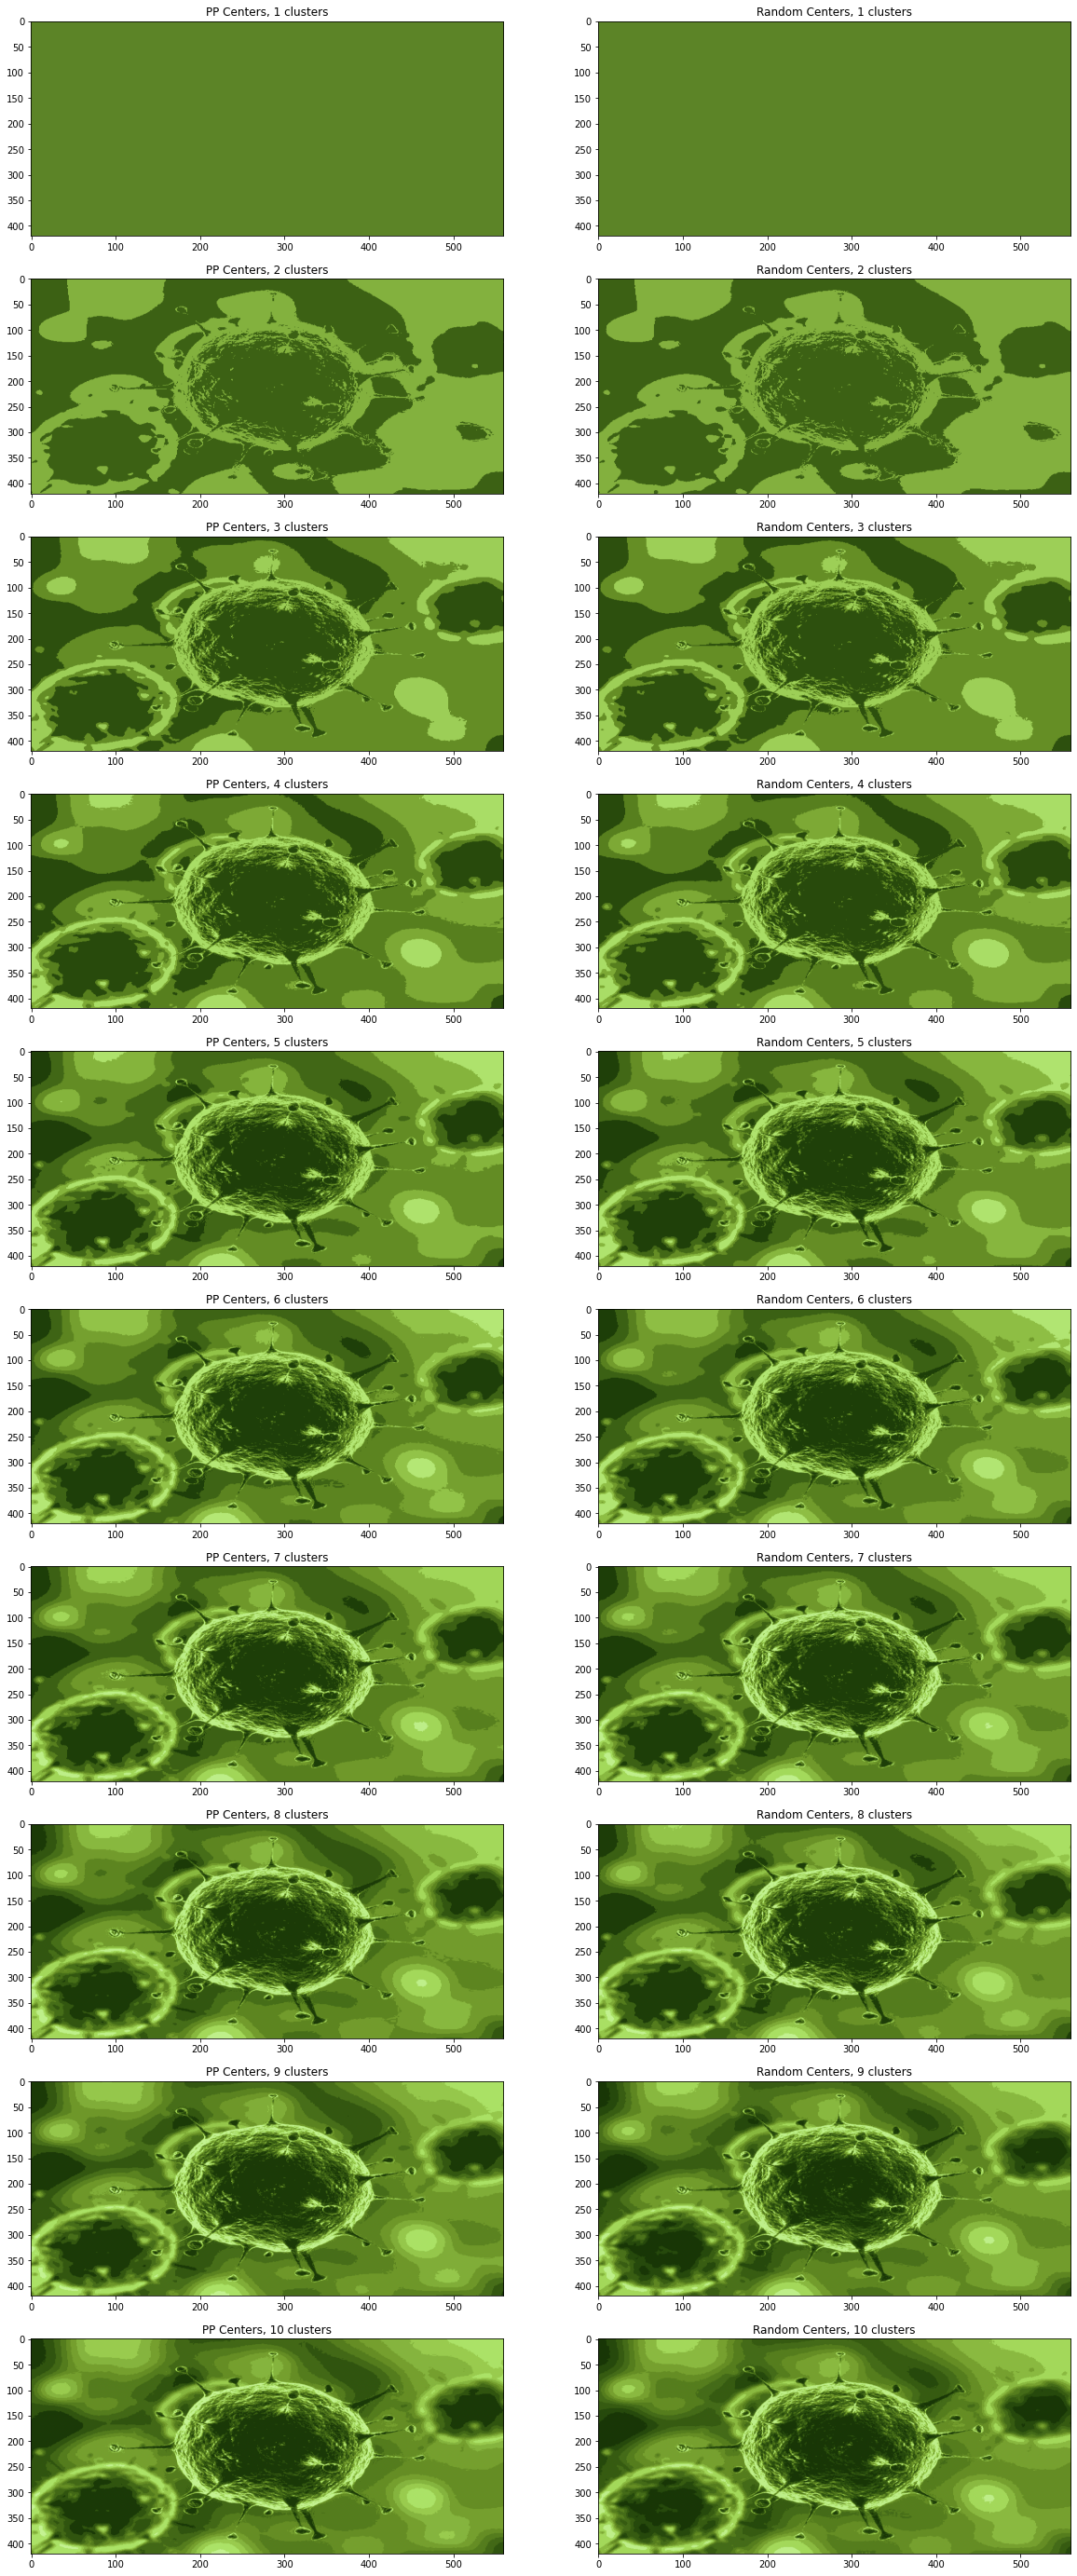

In [18]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(20, 50))

for i, nclusters in enumerate(CLUSTERS_RANGE):
    for j, center_method in enumerate(CENTERS_METHODS):
        axs[i][j].imshow(segmented_images_kmeans_mapping.get(center_method).get(nclusters)[0], aspect='auto');
        axs[i][0].set_title('PP Centers, {} clusters'.format(nclusters))
        axs[i][1].set_title('Random Centers, {} clusters'.format(nclusters))

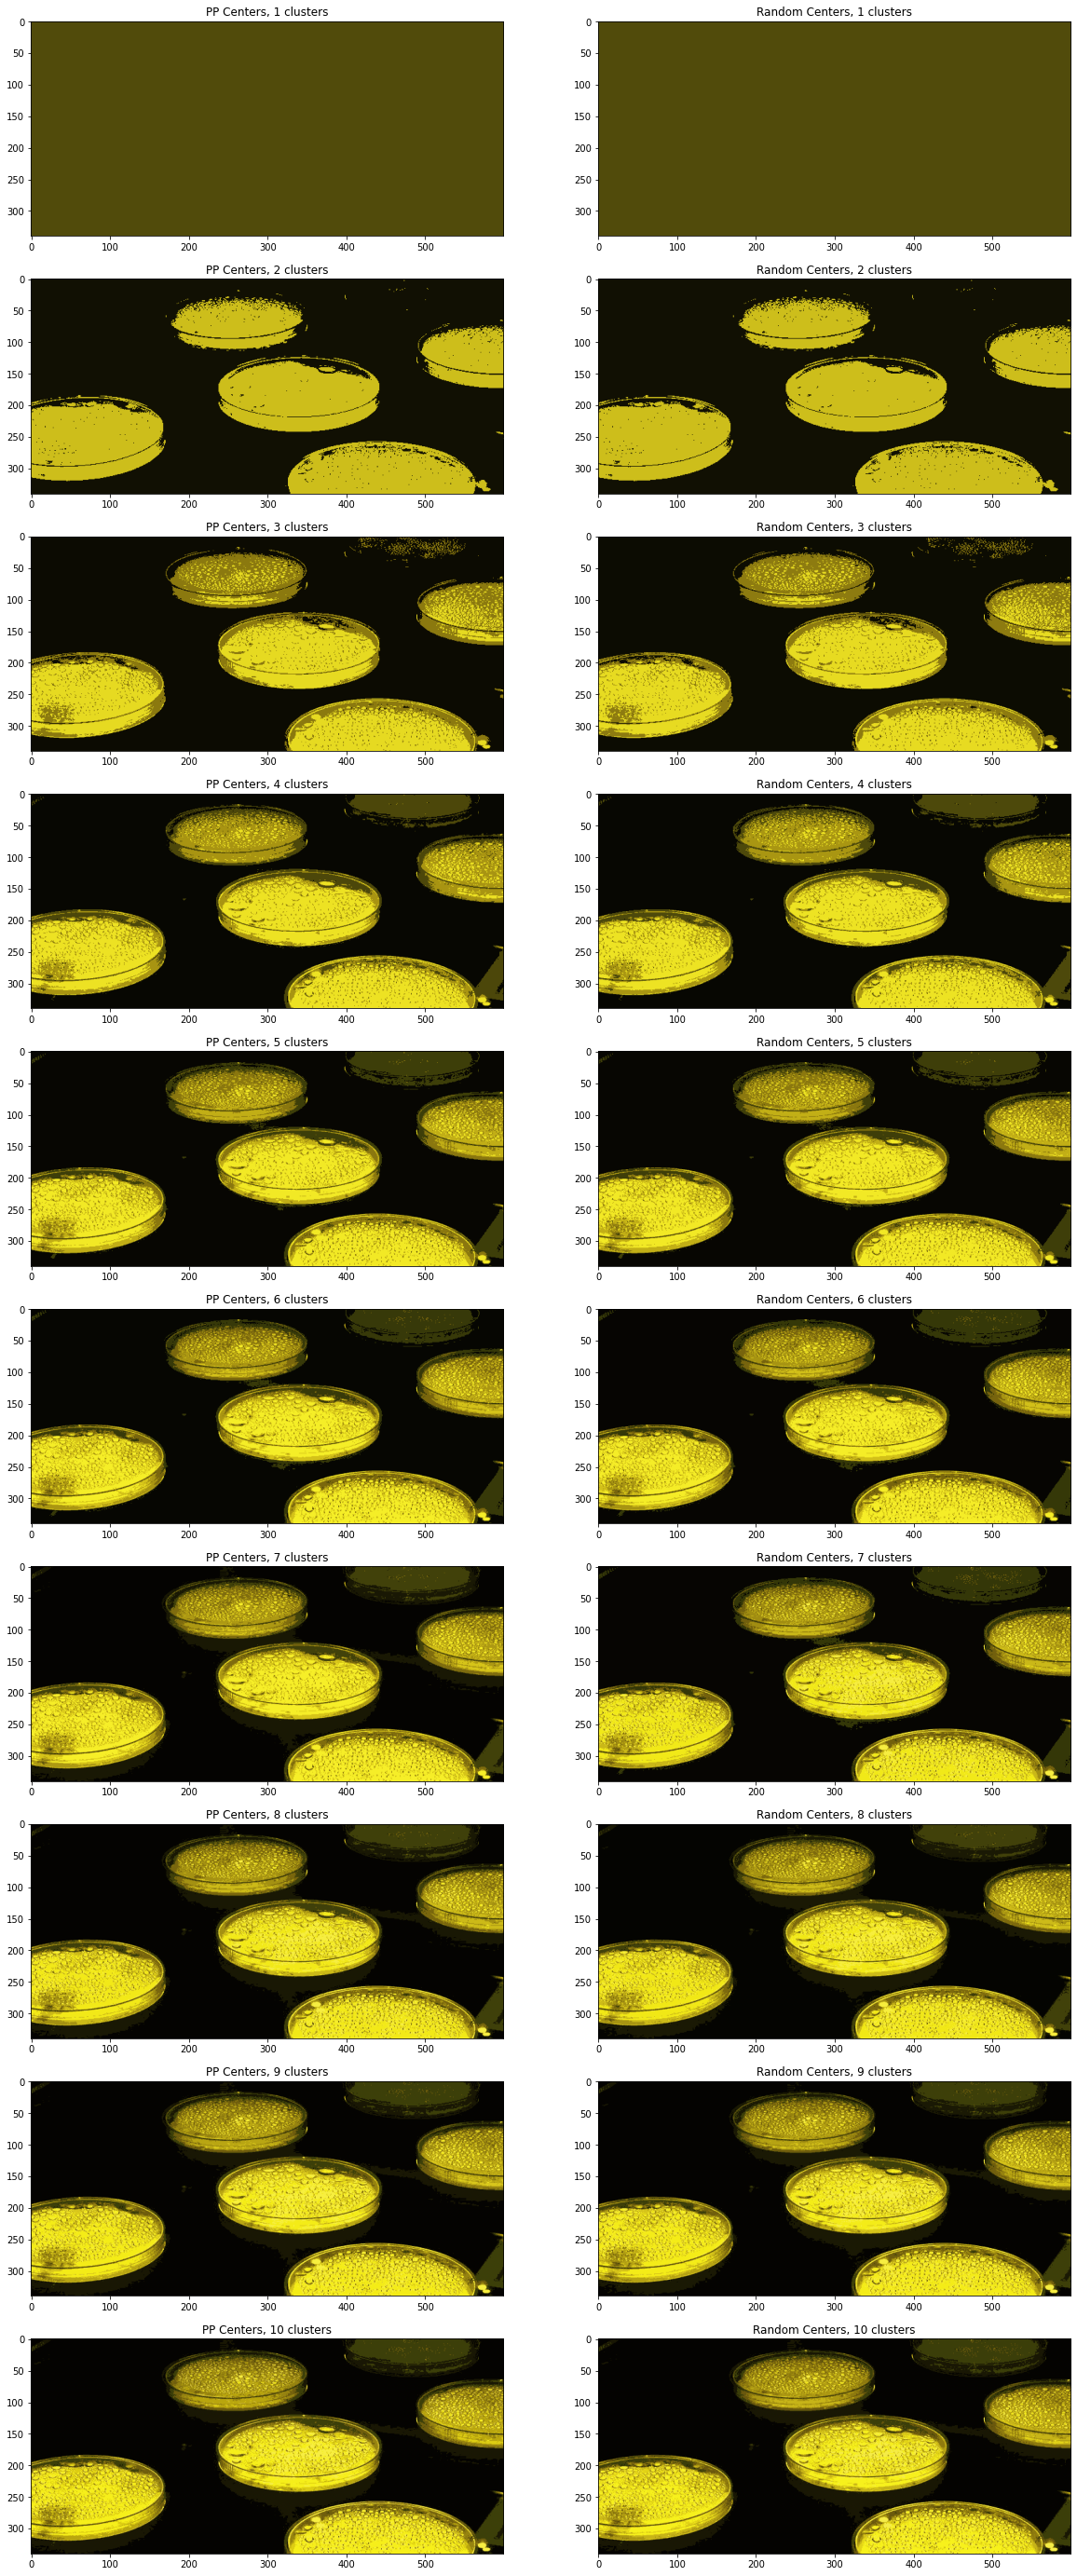

In [19]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(20, 50))

for i, nclusters in enumerate(CLUSTERS_RANGE):
    for j, center_method in enumerate(CENTERS_METHODS):
        axs[i][j].imshow(segmented_images1_kmeans_mapping.get(center_method).get(nclusters)[0], aspect='auto');
        axs[i][0].set_title('PP Centers, {} clusters'.format(nclusters))
        axs[i][1].set_title('Random Centers, {} clusters'.format(nclusters))

#### XIE-BENI

#### First Image

In [27]:
xie_beni_values = [[xie_benie(*segmented_images_kmeans_mapping.get(center_method).get(nclusters))
                    for nclusters in CLUSTERS_RANGE] for center_method in CENTERS_METHODS]

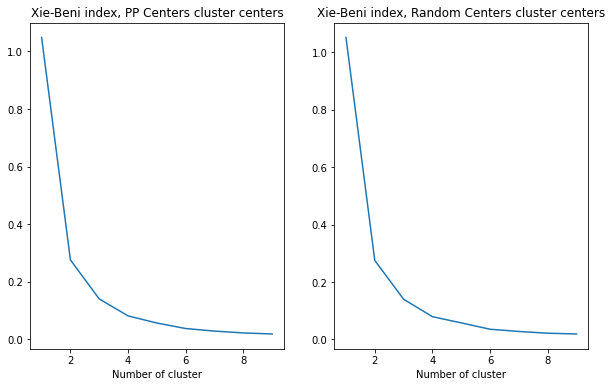

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

center_methods_titles = ('PP Centers', 'Random Centers')
for i in range(2):
    axs[i].plot(xie_beni_values[i])
    axs[i].set_title('Xie-Beni index, {} cluster centers'.format(center_methods_titles[i]))
    axs[i].set_xlabel('Number of cluster')

#### Second Image

In [45]:
xie_beni_values_image1 = [[xie_benie(*segmented_images1_kmeans_mapping.get(center_method).get(nclusters))
                    for nclusters in CLUSTERS_RANGE] for center_method in CENTERS_METHODS]

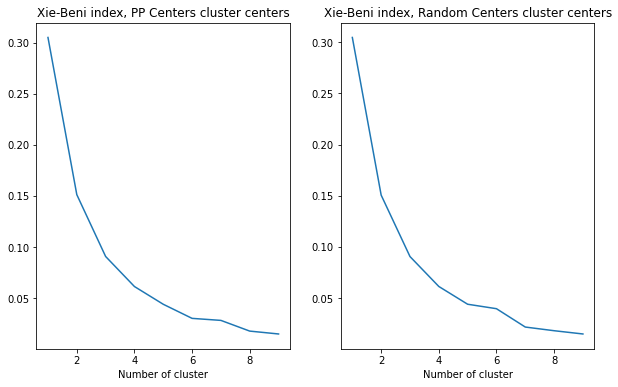

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

center_methods_titles = ('PP Centers', 'Random Centers')
for i in range(2):
    axs[i].plot(xie_beni_values_image1[i])
    axs[i].set_title('Xie-Beni index, {} cluster centers'.format(center_methods_titles[i]))
    axs[i].set_xlabel('Number of cluster')

### Fuzzy C-Means

In [39]:
def fuzzy_cmeans_segmentation(image2d, original_shape, n_clusters, power, eps, max_iter):

    centers, fuzzy_matrix = cmeans(image2d.T, n_clusters, power, eps, max_iter, seed=42)[:2]
    centers = np.uint8(centers)
    
    segmented_image = centers[fuzzy_matrix.argmax(axis=0)]
    segmented_image = segmented_image.reshape(original_shape)
    
    return segmented_image, fuzzy_matrix, centers

In [40]:
M = 2

In [41]:
segmented_images_fuzzy = [fuzzy_cmeans_segmentation(image_2d, image.shape, nclusters, M, EPSILON, MAX_ITER)
                         for nclusters in CLUSTERS_RANGE]

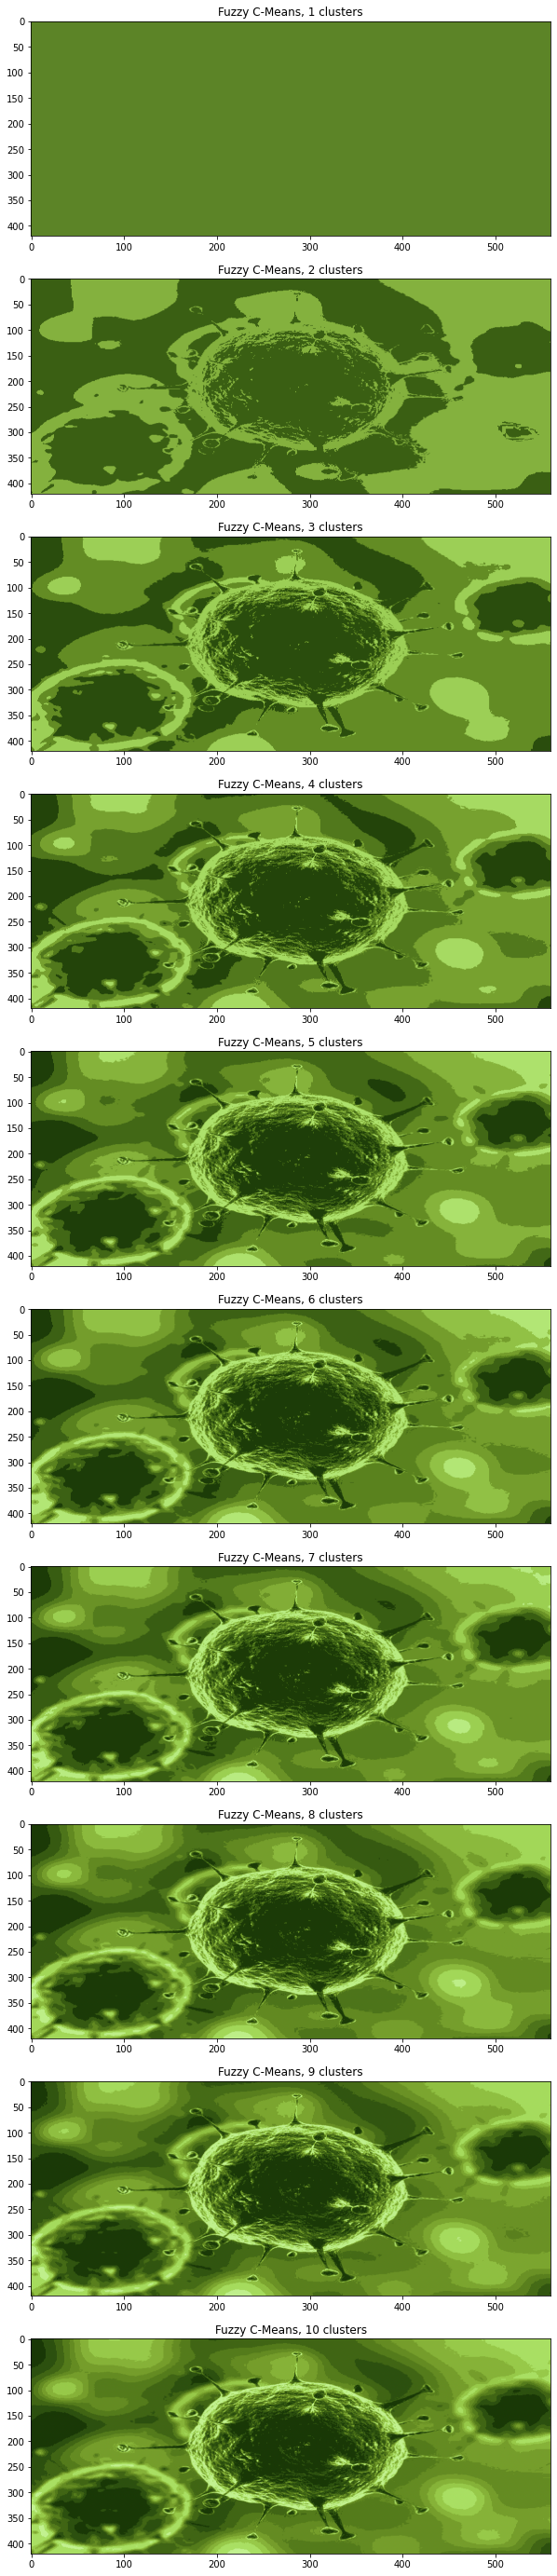

In [42]:
fig, axs = plt.subplots(nrows=len(CLUSTERS_RANGE), ncols=1, figsize=(10, 50))

for i, nclusters in enumerate(CLUSTERS_RANGE):
    axs[i].imshow(segmented_images_fuzzy[i][0], aspect='auto');
    axs[i].set_title('Fuzzy C-Means, {} clusters'.format(nclusters))

In [43]:
segmented_images1_fuzzy = [fuzzy_cmeans_segmentation(image1_2d, image1.shape, nclusters, M, EPSILON, MAX_ITER)
                         for nclusters in CLUSTERS_RANGE]

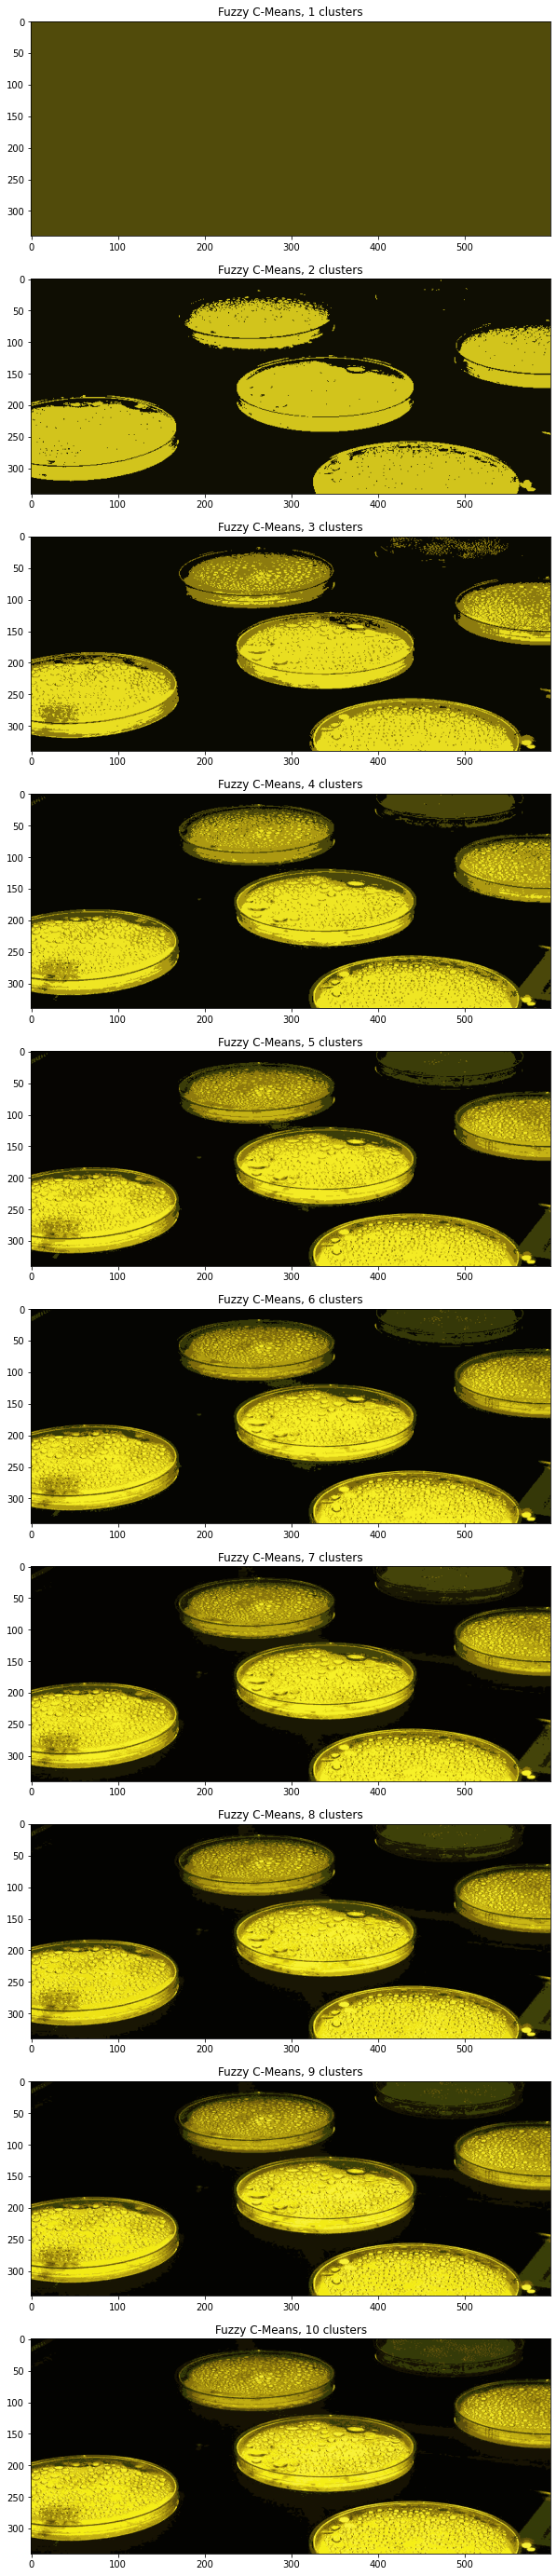

In [44]:
fig, axs = plt.subplots(nrows=len(CLUSTERS_RANGE), ncols=1, figsize=(10, 50))

for i, nclusters in enumerate(CLUSTERS_RANGE):
    axs[i].imshow(segmented_images1_fuzzy[i][0], aspect='auto');
    axs[i].set_title('Fuzzy C-Means, {} clusters'.format(nclusters))

#### XIE-BENI

#### First Image

In [50]:
xie_beni_values_fuzzy_cmeans = [xie_benie(segmented_images_fuzzy[i][0], segmented_images_fuzzy[i][2]) 
                                for i, nclusters in enumerate(CLUSTERS_RANGE)]

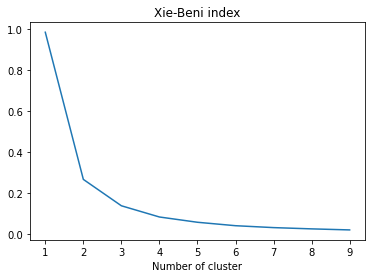

In [57]:
plt.plot(xie_beni_values_fuzzy_cmeans)
plt.title('Xie-Beni index')
plt.xlabel('Number of cluster');

#### Second Image

In [58]:
xie_beni_values_fuzzy_cmeans_image1 = [xie_benie(segmented_images1_fuzzy[i][0], segmented_images_fuzzy[i][2]) 
                                for i, nclusters in enumerate(CLUSTERS_RANGE)]

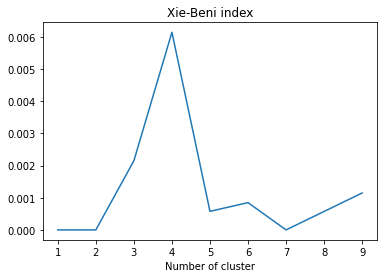

In [59]:
plt.plot(xie_beni_values_fuzzy_cmeans_image1)
plt.title('Xie-Beni index')
plt.xlabel('Number of cluster');